# Computer Vision - Lenet Implementation

20193742 Hyunbin Park

This code was adapted from "JJuOn / pytorch-implementation" in github.

Original Source : https://github.com/JJuOn/pytorch-implementation/blob/main/1.LeNet5.ipynb

## train and test

### setting

In [43]:
import torch

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

import time

from torch.cuda import is_available
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split

%matplotlib inline


In [44]:
transform=transforms.Compose([transforms.Resize((32,32)),
                              transforms.ToTensor()])

all_data=MNIST(root='.',train=True,transform=transform,download=True)

train_ratio=0.8
train_data_len=int(len(all_data)*0.8)
valid_data_len=len(all_data)-train_data_len

train_data,valid_data=random_split(all_data,[train_data_len,valid_data_len])
test_data=MNIST(root='.',train=False,transform=transform,download=True)

In [45]:
batch_size=128

train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=True)
valid_loader=DataLoader(valid_data,batch_size=batch_size,shuffle=False)
test_loader=DataLoader(test_data,batch_size=batch_size,shuffle=False)

### from pytorch-implementation

In [46]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5,self).__init__()
        self.c1=nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5)
        self.s2=nn.AvgPool2d(kernel_size=2)
        self.c3=nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5)
        self.s4=nn.AvgPool2d(kernel_size=2)
        self.c5=nn.Conv2d(in_channels=16,out_channels=120,kernel_size=5)
        self.f6=nn.Linear(in_features=120,out_features=84)
        self.f7=nn.Linear(in_features=84,out_features=10)

    def forward(self,x):
        x=self.c1(x)
        x=self.s2(x)
        x=self.c3(x)
        x=self.s4(x)
        x=self.c5(x).view(-1,120)
        x=self.f6(x)
        x=self.f7(x)
        return x

In [47]:
model=LeNet5()
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [48]:
num_epochs=10
patience=0
early_stop=3
max_acc=-np.inf

train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []
epoch_time_list = []


for epoch in range(num_epochs):
    start_time = time.time()
    train_loss=0
    train_acc=0
    model.train()
    for data,label in train_loader:
        optimizer.zero_grad()
        pred=model(data)
        loss=criterion(pred,label)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*data.size(0)
        train_acc+=pred.argmax(axis=1).eq(label).sum()
    train_loss/=len(train_data)
    train_acc=train_acc.cpu().item()/len(train_data)
    print('Training Epoch {} - Loss : {:.8f} Accuracy : {:.2f}%'.format(epoch,train_loss,train_acc*100))
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    valid_loss=0
    valid_acc=0
    model.eval()
    with torch.no_grad():
        for data,label in valid_loader:
            pred=model(data)
            loss=criterion(pred,label)
            valid_loss=loss.item()*data.size(0)
            valid_acc+=pred.argmax(axis=1).eq(label).sum()
        valid_loss/=len(valid_data)
        valid_acc=valid_acc.cpu().item()/len(valid_data)
        print('Validation Epoch {} - Loss : {:.8f} Accuracy : {:.2f}%'.format(epoch,valid_loss,valid_acc*100))
        valid_loss_list.append(valid_loss)
        valid_acc_list.append(valid_acc)
        if valid_acc>max_acc:
            max_acc=valid_acc
            patience=0
        else:
            patience+=1
        if patience>=early_stop:
            print('Train finished by early stopping')
            break

    end_time = time.time()
    epoch_time = end_time - start_time
    epoch_time_list.append(epoch_time)



Training Epoch 0 - Loss : 0.49409825 Accuracy : 85.71%
Validation Epoch 0 - Loss : 0.00218497 Accuracy : 89.84%
Training Epoch 1 - Loss : 0.34695487 Accuracy : 90.02%
Validation Epoch 1 - Loss : 0.00215504 Accuracy : 90.19%
Training Epoch 2 - Loss : 0.33317812 Accuracy : 90.38%
Validation Epoch 2 - Loss : 0.00208209 Accuracy : 90.54%
Training Epoch 3 - Loss : 0.32739270 Accuracy : 90.54%
Validation Epoch 3 - Loss : 0.00219306 Accuracy : 90.80%
Training Epoch 4 - Loss : 0.32124050 Accuracy : 90.95%
Validation Epoch 4 - Loss : 0.00235688 Accuracy : 90.95%
Training Epoch 5 - Loss : 0.31768886 Accuracy : 90.91%
Validation Epoch 5 - Loss : 0.00188141 Accuracy : 91.17%
Training Epoch 6 - Loss : 0.31518965 Accuracy : 90.95%
Validation Epoch 6 - Loss : 0.00204260 Accuracy : 91.39%
Training Epoch 7 - Loss : 0.31239067 Accuracy : 91.22%
Validation Epoch 7 - Loss : 0.00212619 Accuracy : 91.14%
Training Epoch 8 - Loss : 0.31141051 Accuracy : 91.11%
Validation Epoch 8 - Loss : 0.00229444 Accuracy :

In [49]:
test_loss=0
test_acc=0

for data,label in test_loader:
    pred=model(data)
    loss=criterion(pred,label)
    test_loss+=loss.item()*data.size(0)
    test_acc+=pred.argmax(axis=1).eq(label).sum()
test_loss/=len(test_data)
test_acc=test_acc.cpu().item()/len(test_data)
print('Test Loss : {:.8f} Accuracy : {:.2f}%'.format(test_loss,test_acc*100))

Test Loss : 0.30493779 Accuracy : 91.35%


### maxpooling

In [50]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5,self).__init__()
        self.c1=nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5)
        self.s2=nn.MaxPool2d(kernel_size=2)
        self.c3=nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5)
        self.s4=nn.MaxPool2d(kernel_size=2)
        self.c5=nn.Conv2d(in_channels=16,out_channels=120,kernel_size=5)
        self.f6=nn.Linear(in_features=120,out_features=84)
        self.f7=nn.Linear(in_features=84,out_features=10)

    def forward(self,x):
        x=self.c1(x)
        x=self.s2(x)
        x=self.c3(x)
        x=self.s4(x)
        x=self.c5(x).view(-1,120)
        x=self.f6(x)
        x=self.f7(x)
        return x

In [51]:
model=LeNet5()
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [52]:
num_epochs=10
patience=0
early_stop=3
max_acc=-np.inf

max_train_loss_list = []
max_train_acc_list = []
max_valid_loss_list = []
max_valid_acc_list = []
max_epoch_time_list = []


for epoch in range(num_epochs):
    start_time = time.time()
    train_loss=0
    train_acc=0
    model.train()
    for data,label in train_loader:
        optimizer.zero_grad()
        pred=model(data)
        loss=criterion(pred,label)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*data.size(0)
        train_acc+=pred.argmax(axis=1).eq(label).sum()
    train_loss/=len(train_data)
    train_acc=train_acc.cpu().item()/len(train_data)
    print('Training Epoch {} - Loss : {:.8f} Accuracy : {:.2f}%'.format(epoch,train_loss,train_acc*100))
    max_train_loss_list.append(train_loss)
    max_train_acc_list.append(train_acc)

    valid_loss=0
    valid_acc=0
    model.eval()
    with torch.no_grad():
        for data,label in valid_loader:
            pred=model(data)
            loss=criterion(pred,label)
            valid_loss=loss.item()*data.size(0)
            valid_acc+=pred.argmax(axis=1).eq(label).sum()
        valid_loss/=len(valid_data)
        valid_acc=valid_acc.cpu().item()/len(valid_data)
        print('Validation Epoch {} - Loss : {:.8f} Accuracy : {:.2f}%'.format(epoch,valid_loss,valid_acc*100))
        max_valid_loss_list.append(valid_loss)
        max_valid_acc_list.append(valid_acc)
        if valid_acc>max_acc:
            max_acc=valid_acc
            patience=0
        else:
            patience+=1
        if patience>=early_stop:
            print('Train finished by early stopping')
            break
    
    end_time = time.time()
    epoch_time = end_time - start_time
    max_epoch_time_list.append(epoch_time)

Training Epoch 0 - Loss : 0.35611606 Accuracy : 89.57%
Validation Epoch 0 - Loss : 0.00081649 Accuracy : 95.49%
Training Epoch 1 - Loss : 0.11064430 Accuracy : 96.70%
Validation Epoch 1 - Loss : 0.00039307 Accuracy : 96.94%
Training Epoch 2 - Loss : 0.08375194 Accuracy : 97.41%
Validation Epoch 2 - Loss : 0.00052207 Accuracy : 97.45%
Training Epoch 3 - Loss : 0.07122091 Accuracy : 97.79%
Validation Epoch 3 - Loss : 0.00030772 Accuracy : 97.84%
Training Epoch 4 - Loss : 0.06230056 Accuracy : 98.08%
Validation Epoch 4 - Loss : 0.00043567 Accuracy : 97.71%
Training Epoch 5 - Loss : 0.05723865 Accuracy : 98.25%
Validation Epoch 5 - Loss : 0.00021064 Accuracy : 97.79%
Training Epoch 6 - Loss : 0.05186430 Accuracy : 98.34%
Validation Epoch 6 - Loss : 0.00021646 Accuracy : 98.26%
Training Epoch 7 - Loss : 0.05014233 Accuracy : 98.42%
Validation Epoch 7 - Loss : 0.00028833 Accuracy : 98.10%
Training Epoch 8 - Loss : 0.04617060 Accuracy : 98.57%
Validation Epoch 8 - Loss : 0.00025055 Accuracy :

In [53]:
max_test_loss=0
max_test_acc=0

for data,label in test_loader:
    pred=model(data)
    loss=criterion(pred,label)
    max_test_loss+=loss.item()*data.size(0)
    max_test_acc+=pred.argmax(axis=1).eq(label).sum()
max_test_loss/=len(test_data)
max_test_acc=max_test_acc.cpu().item()/len(test_data)
print('Test Loss : {:.8f} Accuracy : {:.2f}%'.format(max_test_loss,max_test_acc*100))

Test Loss : 0.05790713 Accuracy : 98.24%


### activation function - sigmoid function

In [54]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5,self).__init__()
        self.c1=nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5)
        self.s2=nn.AvgPool2d(kernel_size=2)
        self.c3=nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5)
        self.s4=nn.AvgPool2d(kernel_size=2)
        self.c5=nn.Conv2d(in_channels=16,out_channels=120,kernel_size=5)
        self.f6=nn.Linear(in_features=120,out_features=84)
        self.f7=nn.Linear(in_features=84,out_features=10)

    def forward(self,x):
        x=F.sigmoid(self.c1(x))
        x=self.s2(x)
        x=F.sigmoid(self.c3(x))
        x=self.s4(x)
        x=F.sigmoid(self.c5(x).view(-1,120))
        x=F.sigmoid(self.f6(x))
        x=self.f7(x)
        return x

In [55]:
model=LeNet5()
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [56]:
num_epochs=10
patience=0
early_stop=3
max_acc=-np.inf

sigmoid_train_loss_list = []
sigmoid_train_acc_list = []
sigmoid_valid_loss_list = []
sigmoid_valid_acc_list = []
sigmoid_epoch_time_list = []

for epoch in range(num_epochs):
    start_time = time.time()
    train_loss=0
    train_acc=0
    model.train()
    for data,label in train_loader:
        optimizer.zero_grad()
        pred=model(data)
        loss=criterion(pred,label)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*data.size(0)
        train_acc+=pred.argmax(axis=1).eq(label).sum()
    train_loss/=len(train_data)
    train_acc=train_acc.cpu().item()/len(train_data)
    print('Training Epoch {} - Loss : {:.8f} Accuracy : {:.2f}%'.format(epoch,train_loss,train_acc*100))
    sigmoid_train_loss_list.append(train_loss)
    sigmoid_train_acc_list.append(train_acc)

    valid_loss=0
    valid_acc=0
    model.eval()
    with torch.no_grad():
        for data,label in valid_loader:
            pred=model(data)
            loss=criterion(pred,label)
            valid_loss=loss.item()*data.size(0)
            valid_acc+=pred.argmax(axis=1).eq(label).sum()
        valid_loss/=len(valid_data)
        valid_acc=valid_acc.cpu().item()/len(valid_data)
        print('Validation Epoch {} - Loss : {:.8f} Accuracy : {:.2f}%'.format(epoch,valid_loss,valid_acc*100))
        sigmoid_valid_loss_list.append(valid_loss)
        sigmoid_valid_acc_list.append(valid_acc)
        if valid_acc>max_acc:
            max_acc=valid_acc
            patience=0
        else:
            patience+=1
        if patience>=early_stop:
            print('Train finished by early stopping')
            break

    end_time = time.time()
    epoch_time = end_time - start_time
    sigmoid_epoch_time_list.append(epoch_time)        

Training Epoch 0 - Loss : 1.60940223 Accuracy : 46.84%
Validation Epoch 0 - Loss : 0.00497053 Accuracy : 81.34%
Training Epoch 1 - Loss : 0.44337113 Accuracy : 87.88%
Validation Epoch 1 - Loss : 0.00214316 Accuracy : 90.58%
Training Epoch 2 - Loss : 0.28052762 Accuracy : 91.77%
Validation Epoch 2 - Loss : 0.00166483 Accuracy : 92.51%
Training Epoch 3 - Loss : 0.21582874 Accuracy : 93.46%
Validation Epoch 3 - Loss : 0.00132369 Accuracy : 94.30%
Training Epoch 4 - Loss : 0.17613453 Accuracy : 94.74%
Validation Epoch 4 - Loss : 0.00127376 Accuracy : 94.98%
Training Epoch 5 - Loss : 0.14865306 Accuracy : 95.50%
Validation Epoch 5 - Loss : 0.00102531 Accuracy : 95.51%
Training Epoch 6 - Loss : 0.13068428 Accuracy : 95.96%
Validation Epoch 6 - Loss : 0.00091543 Accuracy : 96.10%
Training Epoch 7 - Loss : 0.11614779 Accuracy : 96.48%
Validation Epoch 7 - Loss : 0.00103779 Accuracy : 96.53%
Training Epoch 8 - Loss : 0.10265040 Accuracy : 96.88%
Validation Epoch 8 - Loss : 0.00089441 Accuracy :

In [57]:
sigmoid_test_loss=0
sigmoid_test_acc=0

for data,label in test_loader:
    pred=model(data)
    loss=criterion(pred,label)
    sigmoid_test_loss+=loss.item()*data.size(0)
    sigmoid_test_acc+=pred.argmax(axis=1).eq(label).sum()
sigmoid_test_loss/=len(test_data)
sigmoid_test_acc=sigmoid_test_acc.cpu().item()/len(test_data)
print('Test Loss : {:.8f} Accuracy : {:.2f}%'.format(sigmoid_test_loss,sigmoid_test_acc*100))

Test Loss : 0.08672882 Accuracy : 97.34%


### activation function - tanh

In [58]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5,self).__init__()
        self.c1=nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5)
        self.s2=nn.AvgPool2d(kernel_size=2)
        self.c3=nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5)
        self.s4=nn.AvgPool2d(kernel_size=2)
        self.c5=nn.Conv2d(in_channels=16,out_channels=120,kernel_size=5)
        self.f6=nn.Linear(in_features=120,out_features=84)
        self.f7=nn.Linear(in_features=84,out_features=10)

    def forward(self,x):
        x=F.tanh(self.c1(x))
        x=self.s2(x)
        x=F.tanh(self.c3(x))
        x=self.s4(x)
        x=F.tanh(self.c5(x).view(-1,120))
        x=F.tanh(self.f6(x))
        x=self.f7(x)
        return x

In [59]:
model=LeNet5()
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [60]:
num_epochs=10
patience=0
early_stop=3
max_acc=-np.inf

tanh_train_loss_list = []
tanh_train_acc_list = []
tanh_valid_loss_list = []
tanh_valid_acc_list = []
tanh_epoch_time_list = []

for epoch in range(num_epochs):
    start_time = time.time()
    train_loss=0
    train_acc=0
    model.train()
    for data,label in train_loader:
        optimizer.zero_grad()
        pred=model(data)
        loss=criterion(pred,label)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*data.size(0)
        train_acc+=pred.argmax(axis=1).eq(label).sum()
    train_loss/=len(train_data)
    train_acc=train_acc.cpu().item()/len(train_data)
    print('Training Epoch {} - Loss : {:.8f} Accuracy : {:.2f}%'.format(epoch,train_loss,train_acc*100))
    tanh_train_loss_list.append(train_loss)
    tanh_train_acc_list.append(train_acc)

    valid_loss=0
    valid_acc=0
    model.eval()
    with torch.no_grad():
        for data,label in valid_loader:
            pred=model(data)
            loss=criterion(pred,label)
            valid_loss=loss.item()*data.size(0)
            valid_acc+=pred.argmax(axis=1).eq(label).sum()
        valid_loss/=len(valid_data)
        valid_acc=valid_acc.cpu().item()/len(valid_data)
        print('Validation Epoch {} - Loss : {:.8f} Accuracy : {:.2f}%'.format(epoch,valid_loss,valid_acc*100))
        tanh_valid_loss_list.append(valid_loss)
        tanh_valid_acc_list.append(valid_acc)
        if valid_acc>max_acc:
            max_acc=valid_acc
            patience=0
        else:
            patience+=1
        if patience>=early_stop:
            print('Train finished by early stopping')
            break

    end_time = time.time()
    epoch_time = end_time - start_time
    tanh_epoch_time_list.append(epoch_time)            

Training Epoch 0 - Loss : 0.43857392 Accuracy : 87.49%
Validation Epoch 0 - Loss : 0.00114555 Accuracy : 94.77%
Training Epoch 1 - Loss : 0.14112301 Accuracy : 95.84%
Validation Epoch 1 - Loss : 0.00086599 Accuracy : 96.36%
Training Epoch 2 - Loss : 0.09639778 Accuracy : 97.01%
Validation Epoch 2 - Loss : 0.00080296 Accuracy : 97.30%
Training Epoch 3 - Loss : 0.07000805 Accuracy : 97.88%
Validation Epoch 3 - Loss : 0.00063181 Accuracy : 97.79%
Training Epoch 4 - Loss : 0.05779655 Accuracy : 98.25%
Validation Epoch 4 - Loss : 0.00035920 Accuracy : 98.02%
Training Epoch 5 - Loss : 0.04568509 Accuracy : 98.59%
Validation Epoch 5 - Loss : 0.00027199 Accuracy : 98.27%
Training Epoch 6 - Loss : 0.03761718 Accuracy : 98.90%
Validation Epoch 6 - Loss : 0.00039596 Accuracy : 98.16%
Training Epoch 7 - Loss : 0.03167129 Accuracy : 99.00%
Validation Epoch 7 - Loss : 0.00047534 Accuracy : 98.39%
Training Epoch 8 - Loss : 0.02649228 Accuracy : 99.23%
Validation Epoch 8 - Loss : 0.00052557 Accuracy :

In [61]:
tanh_test_loss=0
tanh_test_acc=0

for data,label in test_loader:
    pred=model(data)
    loss=criterion(pred,label)
    tanh_test_loss+=loss.item()*data.size(0)
    tanh_test_acc+=pred.argmax(axis=1).eq(label).sum()
tanh_test_loss/=len(test_data)
tanh_test_acc=tanh_test_acc.cpu().item()/len(test_data)
print('Test Loss : {:.8f} Accuracy : {:.2f}%'.format(tanh_test_loss,tanh_test_acc*100))

Test Loss : 0.05206407 Accuracy : 98.51%


### activation function - SoftPlus

In [62]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5,self).__init__()
        self.c1=nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5)
        self.s2=nn.AvgPool2d(kernel_size=2)
        self.c3=nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5)
        self.s4=nn.AvgPool2d(kernel_size=2)
        self.c5=nn.Conv2d(in_channels=16,out_channels=120,kernel_size=5)
        self.f6=nn.Linear(in_features=120,out_features=84)
        self.f7=nn.Linear(in_features=84,out_features=10)

    def forward(self,x):
        x=F.softplus(self.c1(x))
        x=self.s2(x)
        x=F.softplus(self.c3(x))
        x=self.s4(x)
        x=F.softplus(self.c5(x).view(-1,120))
        x=F.softplus(self.f6(x))
        x=self.f7(x)
        return x

In [63]:
model=LeNet5()
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [64]:
num_epochs=10
patience=0
early_stop=3
max_acc=-np.inf

softplus_train_loss_list = []
softplus_train_acc_list = []
softplus_valid_loss_list = []
softplus_valid_acc_list = []
softplus_epoch_time_list = []

for epoch in range(num_epochs):
    start_time = time.time()
    train_loss=0
    train_acc=0
    model.train()
    for data,label in train_loader:
        optimizer.zero_grad()
        pred=model(data)
        loss=criterion(pred,label)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*data.size(0)
        train_acc+=pred.argmax(axis=1).eq(label).sum()
    train_loss/=len(train_data)
    train_acc=train_acc.cpu().item()/len(train_data)
    print('Training Epoch {} - Loss : {:.8f} Accuracy : {:.2f}%'.format(epoch,train_loss,train_acc*100))
    softplus_train_loss_list.append(train_loss)
    softplus_train_acc_list.append(train_acc)

    valid_loss=0
    valid_acc=0
    model.eval()
    with torch.no_grad():
        for data,label in valid_loader:
            pred=model(data)
            loss=criterion(pred,label)
            valid_loss=loss.item()*data.size(0)
            valid_acc+=pred.argmax(axis=1).eq(label).sum()
        valid_loss/=len(valid_data)
        valid_acc=valid_acc.cpu().item()/len(valid_data)
        print('Validation Epoch {} - Loss : {:.8f} Accuracy : {:.2f}%'.format(epoch,valid_loss,valid_acc*100))
        softplus_valid_loss_list.append(valid_loss)
        softplus_valid_acc_list.append(valid_acc)
        if valid_acc>max_acc:
            max_acc=valid_acc
            patience=0
        else:
            patience+=1
        if patience>=early_stop:
            print('Train finished by early stopping')
            break

    end_time = time.time()
    epoch_time = end_time - start_time
    softplus_epoch_time_list.append(epoch_time)            

Training Epoch 0 - Loss : 0.86352108 Accuracy : 69.49%
Validation Epoch 0 - Loss : 0.00175342 Accuracy : 91.79%
Training Epoch 1 - Loss : 0.18695224 Accuracy : 94.12%
Validation Epoch 1 - Loss : 0.00092990 Accuracy : 95.38%
Training Epoch 2 - Loss : 0.12462844 Accuracy : 96.06%
Validation Epoch 2 - Loss : 0.00078538 Accuracy : 96.88%
Training Epoch 3 - Loss : 0.09776328 Accuracy : 96.99%
Validation Epoch 3 - Loss : 0.00080344 Accuracy : 96.90%
Training Epoch 4 - Loss : 0.07675380 Accuracy : 97.59%
Validation Epoch 4 - Loss : 0.00042739 Accuracy : 97.82%
Training Epoch 5 - Loss : 0.06740611 Accuracy : 97.90%
Validation Epoch 5 - Loss : 0.00041256 Accuracy : 97.80%
Training Epoch 6 - Loss : 0.05738609 Accuracy : 98.19%
Validation Epoch 6 - Loss : 0.00064876 Accuracy : 98.14%
Training Epoch 7 - Loss : 0.05059340 Accuracy : 98.38%
Validation Epoch 7 - Loss : 0.00077089 Accuracy : 97.96%
Training Epoch 8 - Loss : 0.04388340 Accuracy : 98.58%
Validation Epoch 8 - Loss : 0.00083465 Accuracy :

In [65]:
softplus_test_loss=0
softplus_test_acc=0

for data,label in test_loader:
    pred=model(data)
    loss=criterion(pred,label)
    softplus_test_loss+=loss.item()*data.size(0)
    softplus_test_acc+=pred.argmax(axis=1).eq(label).sum()
softplus_test_loss/=len(test_data)
softplus_test_acc=softplus_test_acc.cpu().item()/len(test_data)
print('Test Loss : {:.8f} Accuracy : {:.2f}%'.format(softplus_test_loss,softplus_test_acc*100))

Test Loss : 0.05903751 Accuracy : 98.19%


### activation function - ReLU

In [66]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5,self).__init__()
        self.c1=nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5)
        self.s2=nn.AvgPool2d(kernel_size=2)
        self.c3=nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5)
        self.s4=nn.AvgPool2d(kernel_size=2)
        self.c5=nn.Conv2d(in_channels=16,out_channels=120,kernel_size=5)
        self.f6=nn.Linear(in_features=120,out_features=84)
        self.f7=nn.Linear(in_features=84,out_features=10)

    def forward(self,x):
        x=F.relu(self.c1(x))
        x=self.s2(x)
        x=F.relu(self.c3(x))
        x=self.s4(x)
        x=F.relu(self.c5(x).view(-1,120))
        x=F.relu(self.f6(x))
        x=self.f7(x)
        return x

In [67]:
model=LeNet5()
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [68]:
num_epochs=10
patience=0
early_stop=3
max_acc=-np.inf

relu_train_loss_list = []
relu_train_acc_list = []
relu_valid_loss_list = []
relu_valid_acc_list = []
relu_epoch_time_list = []

for epoch in range(num_epochs):
    start_time = time.time()
    train_loss=0
    train_acc=0
    model.train()
    for data,label in train_loader:
        optimizer.zero_grad()
        pred=model(data)
        loss=criterion(pred,label)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*data.size(0)
        train_acc+=pred.argmax(axis=1).eq(label).sum()
    train_loss/=len(train_data)
    train_acc=train_acc.cpu().item()/len(train_data)
    print('Training Epoch {} - Loss : {:.8f} Accuracy : {:.2f}%'.format(epoch,train_loss,train_acc*100))
    relu_train_loss_list.append(train_loss)
    relu_train_acc_list.append(train_acc)

    valid_loss=0
    valid_acc=0
    model.eval()
    with torch.no_grad():
        for data,label in valid_loader:
            pred=model(data)
            loss=criterion(pred,label)
            valid_loss=loss.item()*data.size(0)
            valid_acc+=pred.argmax(axis=1).eq(label).sum()
        valid_loss/=len(valid_data)
        valid_acc=valid_acc.cpu().item()/len(valid_data)
        print('Validation Epoch {} - Loss : {:.8f} Accuracy : {:.2f}%'.format(epoch,valid_loss,valid_acc*100))
        relu_valid_loss_list.append(valid_loss)
        relu_valid_acc_list.append(valid_acc)
        if valid_acc>max_acc:
            max_acc=valid_acc
            patience=0
        else:
            patience+=1
        if patience>=early_stop:
            print('Train finished by early stopping')
            break

    end_time = time.time()
    epoch_time = end_time - start_time
    relu_epoch_time_list.append(epoch_time)              

Training Epoch 0 - Loss : 0.52864893 Accuracy : 83.87%
Validation Epoch 0 - Loss : 0.00136346 Accuracy : 94.38%
Training Epoch 1 - Loss : 0.14439963 Accuracy : 95.54%
Validation Epoch 1 - Loss : 0.00045168 Accuracy : 96.26%
Training Epoch 2 - Loss : 0.09180674 Accuracy : 97.11%
Validation Epoch 2 - Loss : 0.00039626 Accuracy : 97.64%
Training Epoch 3 - Loss : 0.07140040 Accuracy : 97.81%
Validation Epoch 3 - Loss : 0.00022548 Accuracy : 97.80%
Training Epoch 4 - Loss : 0.06109030 Accuracy : 98.09%
Validation Epoch 4 - Loss : 0.00024854 Accuracy : 98.41%
Training Epoch 5 - Loss : 0.05067084 Accuracy : 98.40%
Validation Epoch 5 - Loss : 0.00016169 Accuracy : 98.33%
Training Epoch 6 - Loss : 0.04578682 Accuracy : 98.57%
Validation Epoch 6 - Loss : 0.00021371 Accuracy : 98.41%
Training Epoch 7 - Loss : 0.03956126 Accuracy : 98.77%
Validation Epoch 7 - Loss : 0.00016112 Accuracy : 98.50%
Training Epoch 8 - Loss : 0.03584447 Accuracy : 98.85%
Validation Epoch 8 - Loss : 0.00017260 Accuracy :

In [69]:
relu_test_loss=0
relu_test_acc=0

for data,label in test_loader:
    pred=model(data)
    loss=criterion(pred,label)
    relu_test_loss+=loss.item()*data.size(0)
    relu_test_acc+=pred.argmax(axis=1).eq(label).sum()
relu_test_loss/=len(test_data)
relu_test_acc=relu_test_acc.cpu().item()/len(test_data)
print('Test Loss : {:.8f} Accuracy : {:.2f}%'.format(relu_test_loss,relu_test_acc*100))

Test Loss : 0.03937371 Accuracy : 98.79%


## result

### epoch time

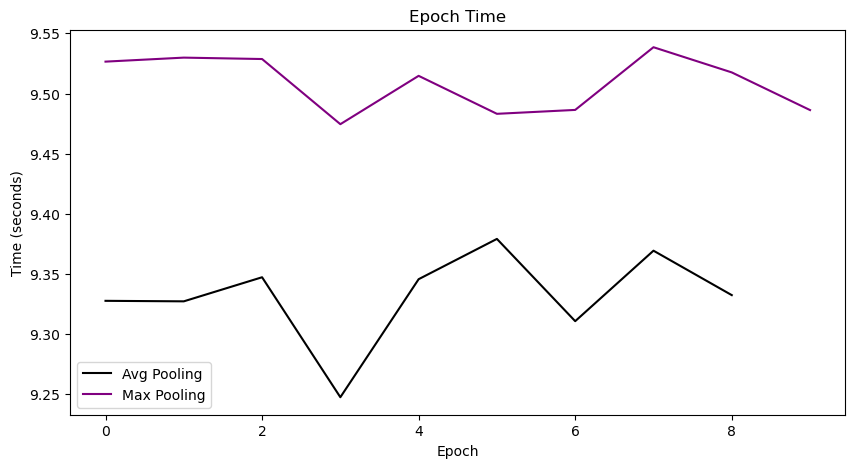

In [70]:
# Plotting epoch times
plt.figure(figsize=(10, 5))
plt.plot(epoch_time_list, label='Avg Pooling', color='black')
plt.plot(max_epoch_time_list, label='Max Pooling', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.title('Epoch Time')
plt.legend()
plt.show()

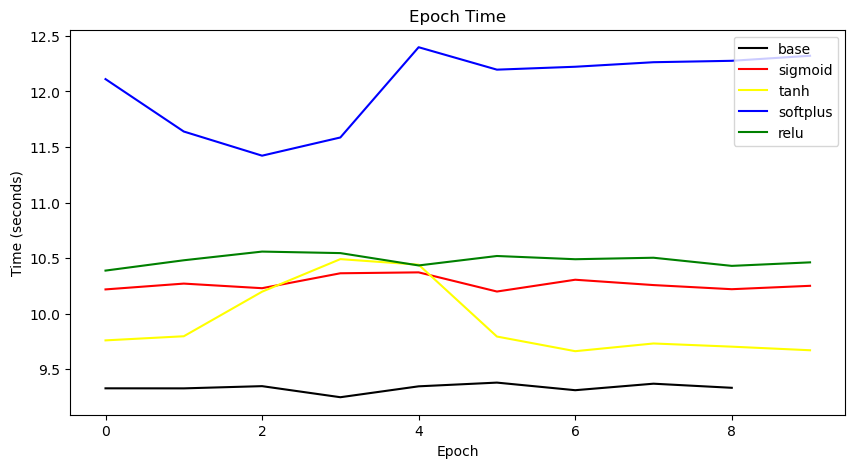

In [71]:
# Plotting epoch times
plt.figure(figsize=(10, 5))
plt.plot(epoch_time_list, label='base', color='black')
plt.plot(sigmoid_epoch_time_list, label='sigmoid', color='red')
plt.plot(tanh_epoch_time_list, label='tanh', color='yellow')
plt.plot(softplus_epoch_time_list, label='softplus', color='blue')
plt.plot(relu_epoch_time_list, label='relu', color='green')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.title('Epoch Time')
plt.legend()
plt.show()

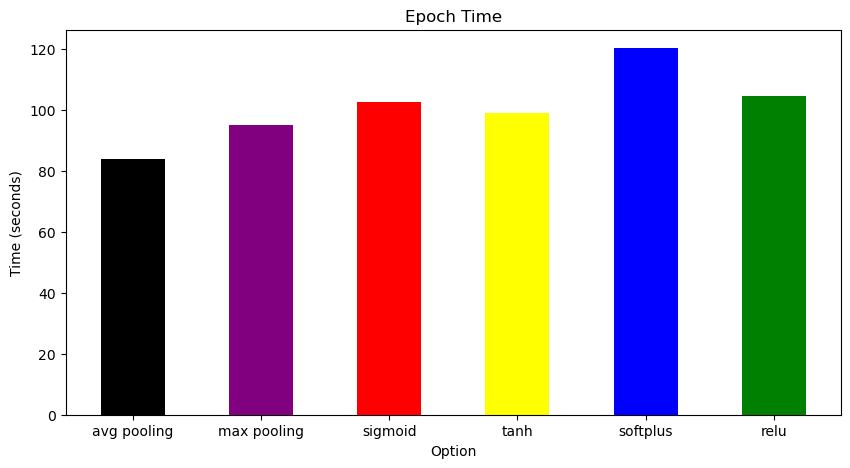

In [72]:
# Plotting epoch times
total_epoch_time_list = []
total_epoch_time_list.append(sum(epoch_time_list))
total_epoch_time_list.append(sum(max_epoch_time_list))
total_epoch_time_list.append(sum(sigmoid_epoch_time_list))
total_epoch_time_list.append(sum(tanh_epoch_time_list))
total_epoch_time_list.append(sum(softplus_epoch_time_list))
total_epoch_time_list.append(sum(relu_epoch_time_list))

plt.figure(figsize=(10, 5))
plt.bar('avg pooling', sum(epoch_time_list), width=0.5, color='black')
plt.bar('max pooling', sum(max_epoch_time_list), width=0.5, color='purple')
plt.bar('sigmoid', sum(sigmoid_epoch_time_list), width=0.5, color='red')
plt.bar('tanh', sum(tanh_epoch_time_list), width=0.5, color='yellow')
plt.bar('softplus', sum(softplus_epoch_time_list), width=0.5, color='blue')
plt.bar('relu', sum(relu_epoch_time_list), width=0.5, color='green')

plt.xlabel('Option')
plt.ylabel('Time (seconds)')
plt.title('Epoch Time')
plt.show()

### training

#### base

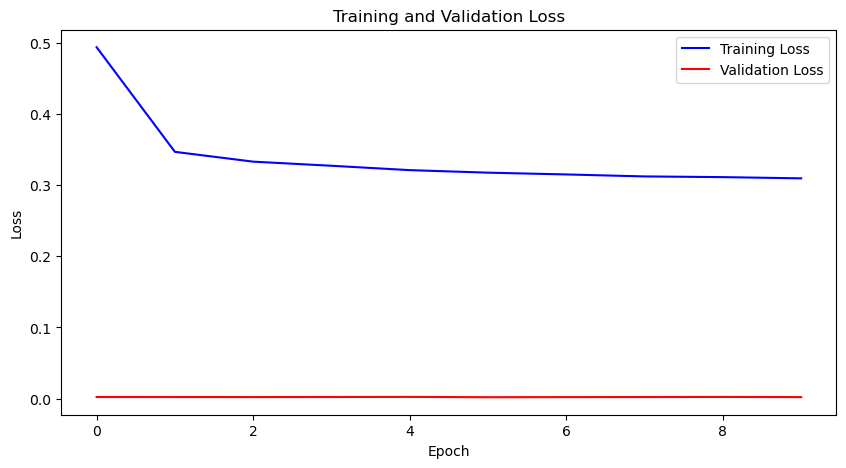

In [73]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Training Loss', color='blue')
plt.plot(valid_loss_list, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

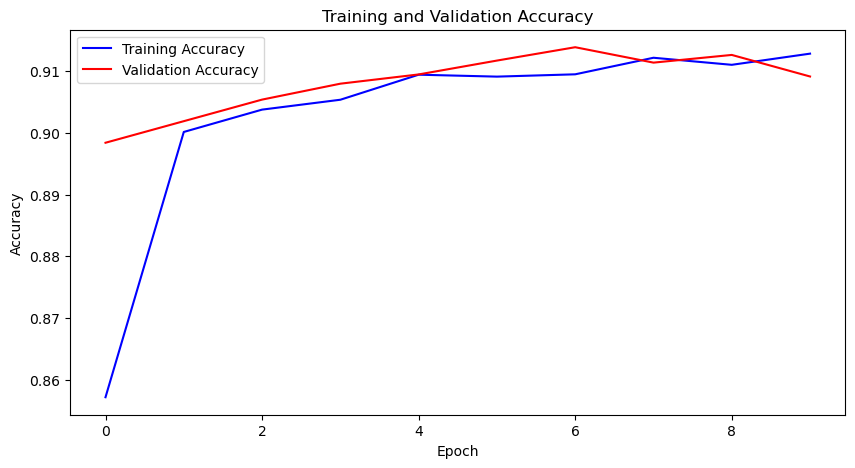

In [74]:
# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc_list, label='Training Accuracy', color='blue')
plt.plot(valid_acc_list, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

#### loss

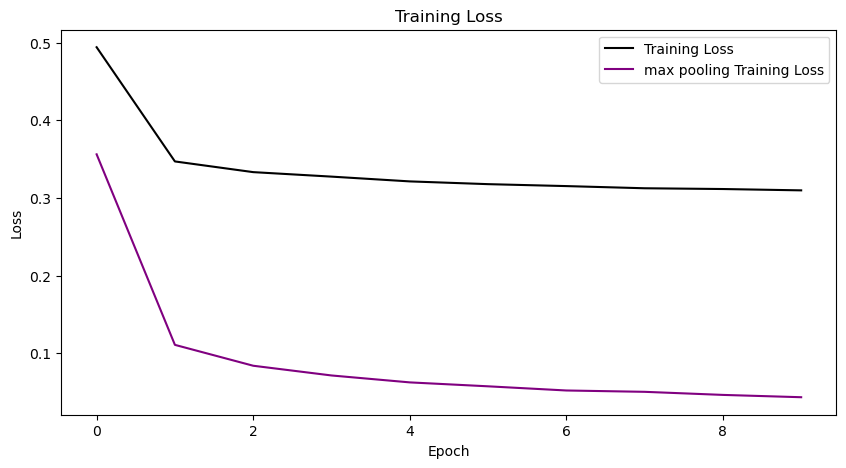

In [75]:
# Plotting training loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Training Loss', color='black')
plt.plot(max_train_loss_list, label='max pooling Training Loss', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

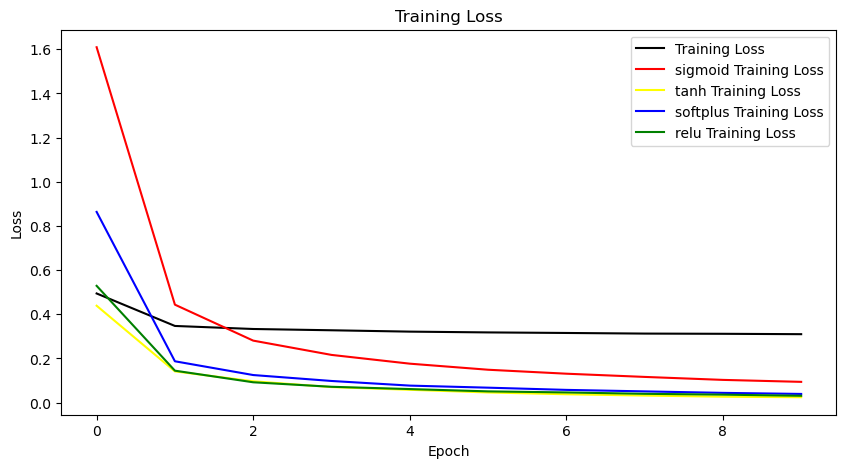

In [76]:
# Plotting training loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Training Loss', color='black')
plt.plot(sigmoid_train_loss_list, label='sigmoid Training Loss', color='red')
plt.plot(tanh_train_loss_list, label='tanh Training Loss', color='yellow')
plt.plot(softplus_train_loss_list, label='softplus Training Loss', color='blue')
plt.plot(relu_train_loss_list, label='relu Training Loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

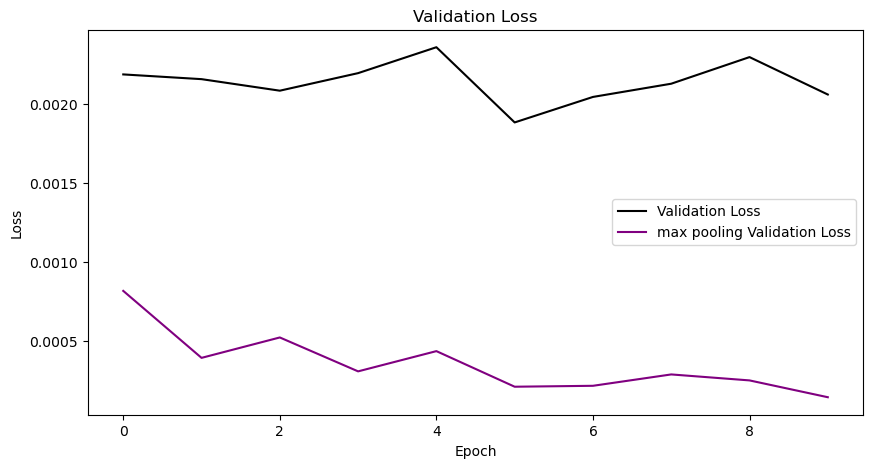

In [77]:
# Plotting validation loss
plt.figure(figsize=(10, 5))
plt.plot(valid_loss_list, label='Validation Loss', color='black')
plt.plot(max_valid_loss_list, label='max pooling Validation Loss', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.show()

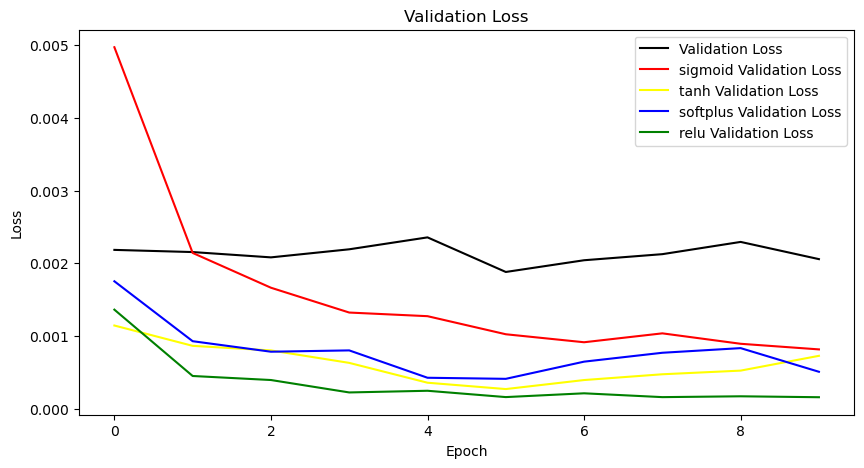

In [78]:
# Plotting validation loss
plt.figure(figsize=(10, 5))
plt.plot(valid_loss_list, label='Validation Loss', color='black')
plt.plot(sigmoid_valid_loss_list, label='sigmoid Validation Loss', color='red')
plt.plot(tanh_valid_loss_list, label='tanh Validation Loss', color='yellow')
plt.plot(softplus_valid_loss_list, label='softplus Validation Loss', color='blue')
plt.plot(relu_valid_loss_list, label='relu Validation Loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.show()

#### accuracy

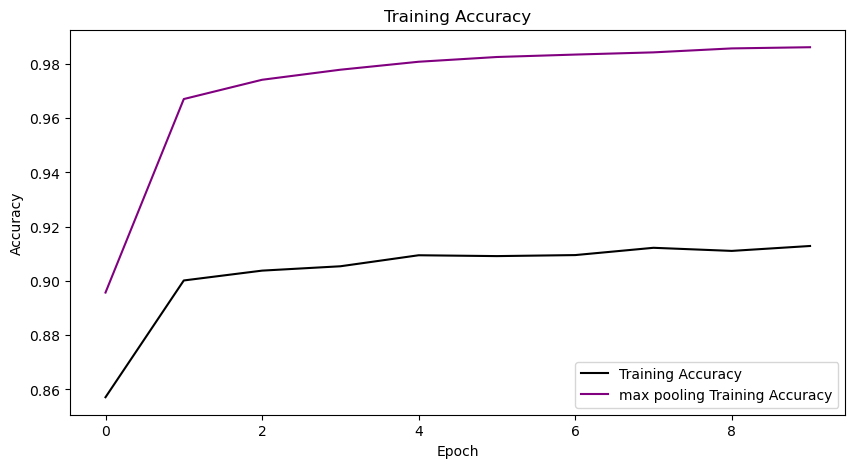

In [79]:
# Plotting training Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc_list, label='Training Accuracy', color='black')
plt.plot(max_train_acc_list, label='max pooling Training Accuracy', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

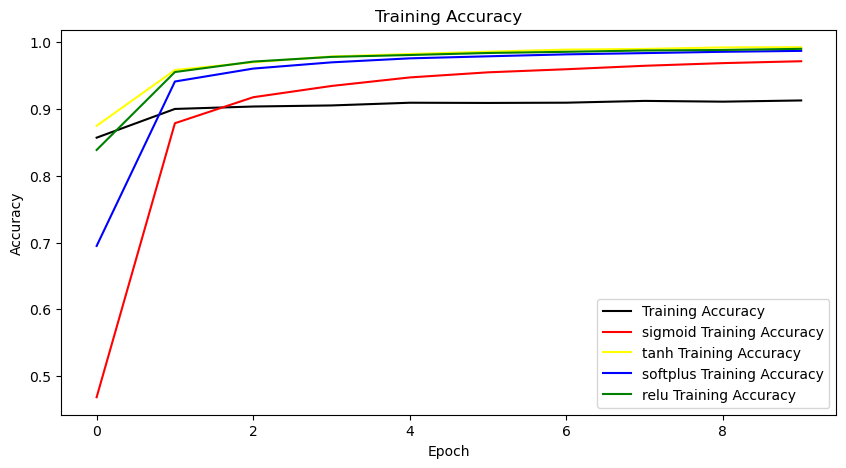

In [80]:
# Plotting training Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc_list, label='Training Accuracy', color='black')
plt.plot(sigmoid_train_acc_list, label='sigmoid Training Accuracy', color='red')
plt.plot(tanh_train_acc_list, label='tanh Training Accuracy', color='yellow')
plt.plot(softplus_train_acc_list, label='softplus Training Accuracy', color='blue')
plt.plot(relu_train_acc_list, label='relu Training Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

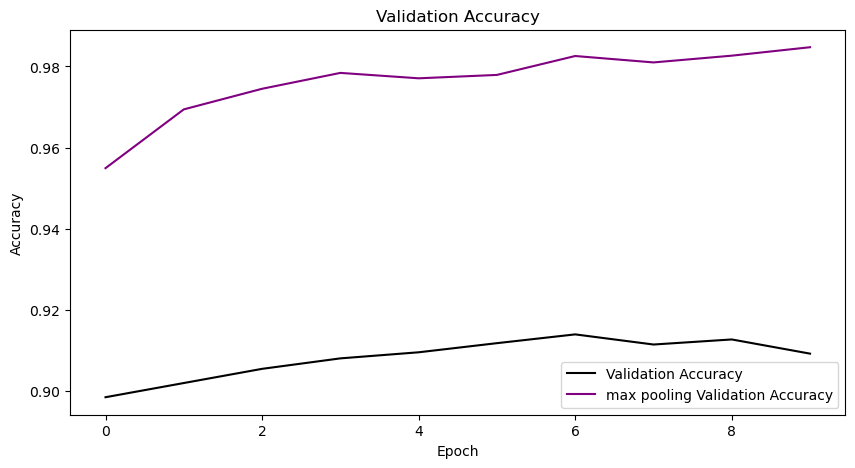

In [81]:
# Plotting validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(valid_acc_list, label='Validation Accuracy', color='black')
plt.plot(max_valid_acc_list, label='max pooling Validation Accuracy', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

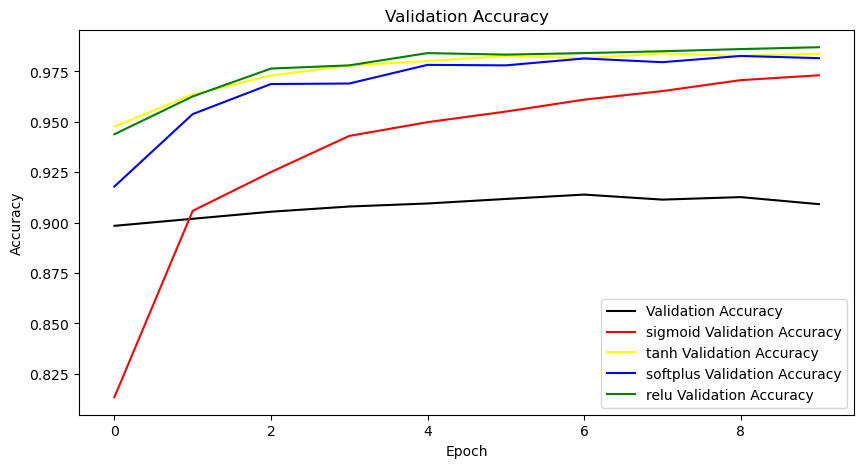

In [82]:
# Plotting validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(valid_acc_list, label='Validation Accuracy', color='black')
plt.plot(sigmoid_valid_acc_list, label='sigmoid Validation Accuracy', color='red')
plt.plot(tanh_valid_acc_list, label='tanh Validation Accuracy', color='yellow')
plt.plot(softplus_valid_acc_list, label='softplus Validation Accuracy', color='blue')
plt.plot(relu_valid_acc_list, label='relu Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

#### test loss and accuracy

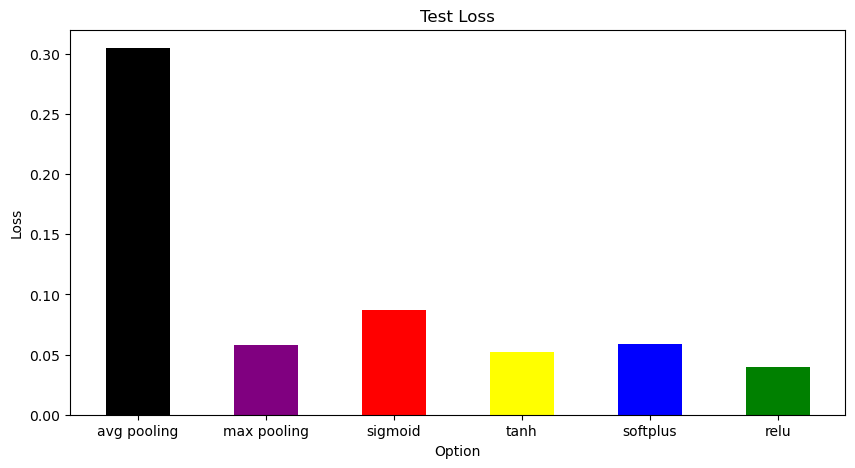

In [83]:
# Plotting test Loss


plt.figure(figsize=(10, 5))
plt.bar('avg pooling', test_loss, width=0.5, color='black')
plt.bar('max pooling', max_test_loss, width=0.5, color='purple')
plt.bar('sigmoid', sigmoid_test_loss, width=0.5, color='red')
plt.bar('tanh', tanh_test_loss, width=0.5, color='yellow')
plt.bar('softplus', softplus_test_loss, width=0.5, color='blue')
plt.bar('relu', relu_test_loss, width=0.5, color='green')

plt.xlabel('Option')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.show()

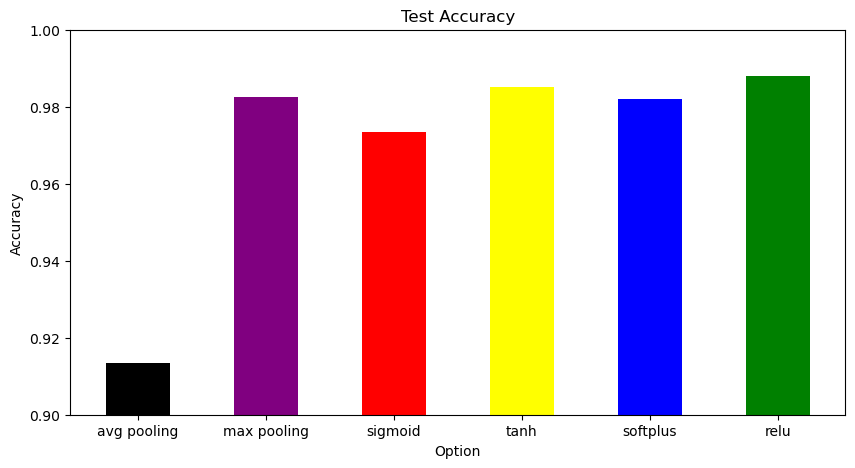

In [84]:
# Plotting test accuracy


plt.figure(figsize=(10, 5))
plt.bar('avg pooling', test_acc, width=0.5, color='black')
plt.bar('max pooling', max_test_acc, width=0.5, color='purple')
plt.bar('sigmoid', sigmoid_test_acc, width=0.5, color='red')
plt.bar('tanh', tanh_test_acc, width=0.5, color='yellow')
plt.bar('softplus', softplus_test_acc, width=0.5, color='blue')
plt.bar('relu', relu_test_acc, width=0.5, color='green')

plt.ylim(0.9, 1)
plt.xlabel('Option')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.show()